<h1>Chargement du modèle</h1>

In [ ]:
import pandas as pd
df = pd.read_csv('data/original.csv')
max_per_class = 10000
batch_size = 32
for rating in range(1,6):
    df_rating = df[df['rating'] == rating]
    if len(df_rating) > max_per_class:
        df = df.drop(df_rating.index[max_per_class:])

C:\Users\Steffen\AppData\Local\Temp\ipykernel_1400\4150805002.py:2: DtypeWarning: Columns (5) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('reviews_FINAL.csv')


In [8]:
df["day_diff"] = pd.to_datetime(df["dates.publishedDate"]) - pd.to_datetime(df["dates.experiencedDate"])
df["day_diff"] = df["day_diff"].dt.days.fillna(0)
df = df[["rating", "text", "day_diff"]]

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from transformers import BertTokenizer, BertModel
from torch.utils.data import Dataset, DataLoader
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")


class ReviewDataset(Dataset):
    def __init__(self, texts, metadata, labels, tokenizer, max_len=128):
        self.texts = texts
        self.metadata = metadata
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts[idx]
        metadata = torch.tensor(self.metadata[idx], dtype=torch.float32)
        label = torch.tensor(self.labels[idx], dtype=torch.float32)
        
        encoding = self.tokenizer(text, truncation=True, padding='max_length', max_length=self.max_len, return_tensors="pt")
        
        return {
            'input_ids': encoding['input_ids'].squeeze(0),
            'attention_mask': encoding['attention_mask'].squeeze(0),
            'metadata': metadata,
            'label': label
        }


class BERTWithMetadata(nn.Module):
    def __init__(self, bert_model_name, metadata_dim, hidden_dim=128, num_classes=1):
        super(BERTWithMetadata, self).__init__()
        self.bert = BertModel.from_pretrained(bert_model_name) # Init du modèle Bert
        self.metadata_fc = nn.Linear(metadata_dim, hidden_dim) # Couche linéaire pour les métadonnées
        self.fc1 = nn.Linear(self.bert.config.hidden_size + hidden_dim, hidden_dim) # Combinaison Bert + Métadonnées
        self.fc2 = nn.Linear(hidden_dim, num_classes) # Transformation finale vers la prédiction
        self.dropout = nn.Dropout(0.3) # Dropout de 30% contre l'overfitting
        self.relu = nn.ReLU() # Fonction d'activation ReLU
        
    def forward(self, input_ids, attention_mask, metadata):
        bert_output = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        text_features = bert_output.pooler_output
        
        metadata_features = self.relu(self.metadata_fc(metadata))
        
        combined = torch.cat((text_features, metadata_features), dim=1)
        x = self.relu(self.fc1(combined))
        x = self.dropout(x)
        output = self.fc2(x)
        
        return output


def train_model(texts, metadata, labels, tokenizer):

    
    dataset = ReviewDataset(texts, metadata, labels, tokenizer)
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
    
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = BERTWithMetadata("bert-base-uncased", metadata_dim=1).to(device)
    
    criterion = nn.MSELoss()
    optimizer = optim.AdamW(model.parameters(), lr=2e-5)
    
    model.train()
    for epoch in range(3):
        # torch.cuda.empty_cache()
        for batch in dataloader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            metadata = batch['metadata'].to(device)
            labels = batch['label'].to(device).unsqueeze(1)
            
            optimizer.zero_grad()
            outputs = model(input_ids, attention_mask, metadata)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            print(f"Epoch {epoch+1}, Loss: {loss.item():.4f}")
    return(model)

# train_model()



d:\Steffen\Documents\DL_project\.venv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
from sklearn.metrics import mean_squared_error
import numpy as np

def test_model(model, test_texts, test_metadata, test_labels, tokenizer, batch_size=32, max_len=128):
    
    test_dataset = ReviewDataset(test_texts, test_metadata, test_labels, tokenizer, max_len=max_len)
    test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
    
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = model.to(device)
    model.eval()
    
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        for batch in test_dataloader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            metadata = batch['metadata'].to(device)
            labels = batch['label'].to(device).unsqueeze(1)
            
            # Prédictions
            outputs = model(input_ids, attention_mask, metadata)
            
            all_preds.append(outputs.cpu().numpy())
            all_labels.append(labels.cpu().numpy())


    all_preds = np.concatenate(all_preds, axis=0)
    all_labels = np.concatenate(all_labels, axis=0)


    mse = mean_squared_error(all_labels, all_preds)
    print(f'Mean Squared Error (MSE) on the test set: {mse:.4f}')
    
    for i in range(5):
        print(f"Predicted: {all_preds[i].item()}, Actual: {all_labels[i].item()}")
    return(all_preds)

In [4]:
model = BERTWithMetadata("bert-base-uncased", metadata_dim=1).to(device)

In [5]:
model.load_state_dict(torch.load(f"model_reg_10000_classes_32_bathsize.pth"))

<All keys matched successfully>

In [9]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(df[["text", "day_diff"]], df["rating"], test_size=0.2, random_state=42)

In [10]:
# Charger le modèle pré-entrainé et l'utiliser pour faire des prédictions sur les données de test
all_preds = test_model(model, x_test["text"].values, x_test[["day_diff"]].values, y_test.values, tokenizer)

Mean Squared Error (MSE) on the test set: 0.5692
Predicted: 0.9877808094024658, Actual: 1.0
Predicted: 4.7534637451171875, Actual: 4.0
Predicted: 1.0721676349639893, Actual: 1.0
Predicted: 1.8748422861099243, Actual: 3.0
Predicted: 4.467531681060791, Actual: 4.0


              precision    recall  f1-score   support

           1       0.68      0.54      0.60      1952
           2       0.40      0.56      0.47      2017
           3       0.49      0.45      0.47      2075
           4       0.48      0.67      0.56      2007
           5       0.80      0.38      0.51      1949

    accuracy                           0.52     10000
   macro avg       0.57      0.52      0.52     10000
weighted avg       0.57      0.52      0.52     10000

RMSE : 0.8182909018191513


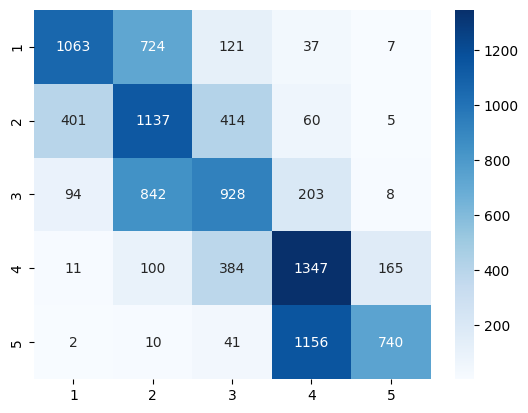

In [12]:
from sklearn.metrics import confusion_matrix, classification_report, root_mean_squared_error
import seaborn as sns
y_pred = all_preds.copy()
y_pred = y_pred.round().astype(int).squeeze()
y_pred[y_pred>5] = 5
cm = confusion_matrix(y_test.values, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=range(min(y_pred), max(y_pred)+1), yticklabels=range(min(y_test), max(y_test)+1))
print(classification_report(y_test.values, y_pred))
print(f"RMSE : {root_mean_squared_error(y_test.values, y_pred)}")

In [1]:
# x_test["real"] = y_test
i = 1
mask = abs(x_test["real"]- x_test["predict"]) == i
x_test.loc[mask, ["real", "predict", "text"]].sample(1).to_clipboard(excel=True, sep="\t")

NameError: name 'x_test' is not defined